In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import platform
%matplotlib inline

In [3]:
class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.training_images = X
        self.training_labels = y

    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.training_images.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.training_images), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.training_images.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.training_labels[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

In [4]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [5]:
cifar10_dir = '/content/drive/MyDrive/cifar-10-batches-py/'
training_images, training_labels, testing_images, testing_labels = load_CIFAR10(cifar10_dir)

In [6]:
print(f"shape of training_images: {training_images.shape}")
print(f"shape of training_labels: {training_labels.shape}")
print(f"shape of testing_images: {testing_images.shape}")
print(f"shape of testing_labels: {testing_labels.shape}")

shape of training_images: (50000, 32, 32, 3)
shape of training_labels: (50000,)
shape of testing_images: (10000, 32, 32, 3)
shape of testing_labels: (10000,)


In [7]:
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

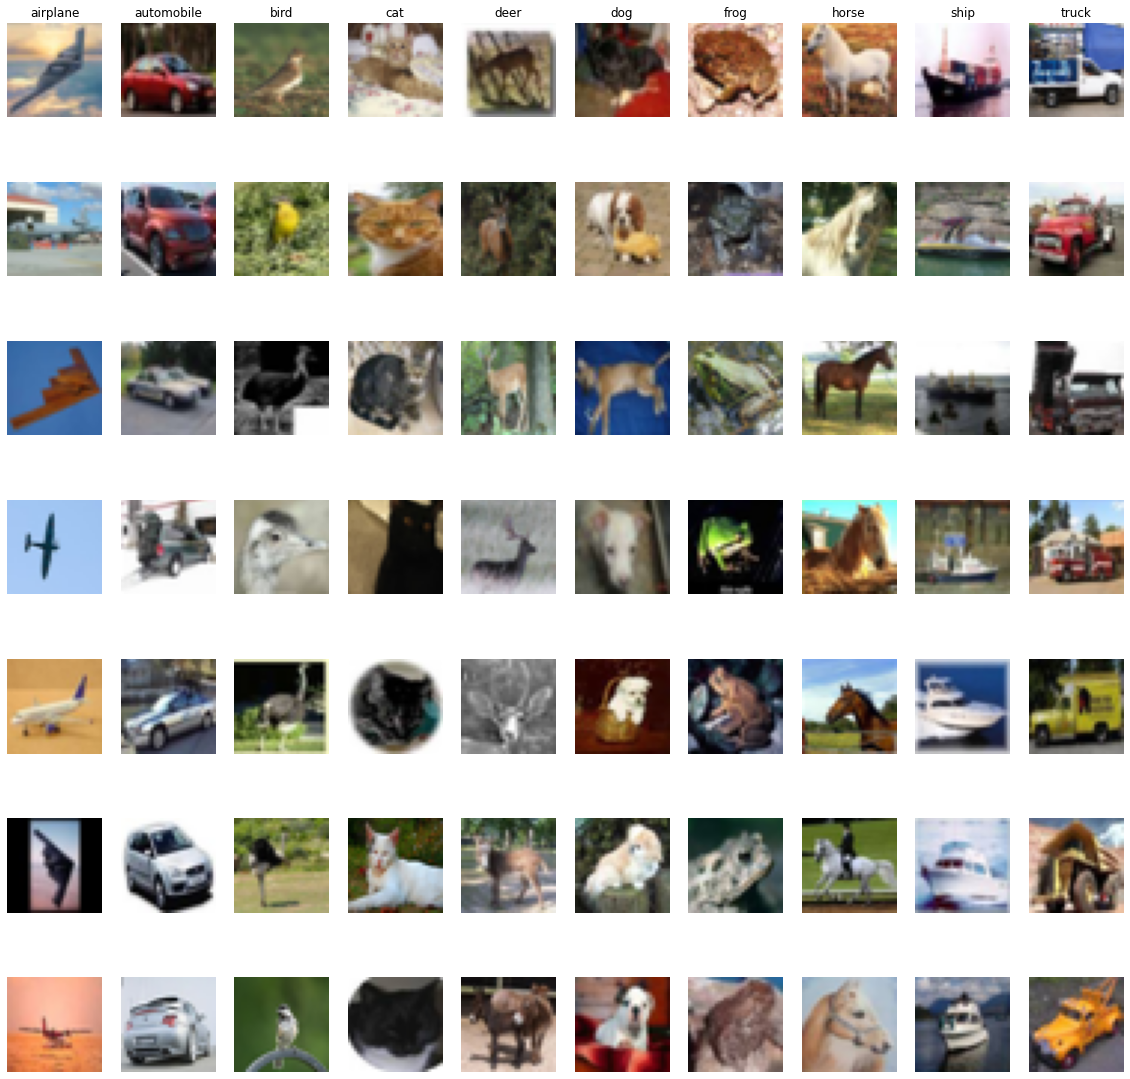

In [8]:
num_categories = len(categories)
samples_per_class = 7
plt.figure(figsize = (20, 20))
for y, cls in enumerate(categories):
    idxs = np.flatnonzero(training_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_categories + y + 1
        plt.subplot(samples_per_class, num_categories, plt_idx)
        plt.imshow(training_images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
num_training = 10000
mask = list(range(num_training))
training_images = training_images[mask]
training_labels = training_labels[mask]

num_test = 1000
mask = list(range(num_test))
testing_images = testing_images[mask]
testing_labels = testing_labels[mask]

In [10]:
training_images = np.reshape(training_images, (training_images.shape[0], -1))
testing_images = np.reshape(testing_images, (testing_images.shape[0], -1))
print(training_images.shape, testing_images.shape)

(10000, 3072) (1000, 3072)


In [11]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

training_images_folds = []
training_labels_folds = []

training_images_folds = np.array_split(training_images,num_folds)
training_labels_folds = np.array_split(training_labels,num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        testing_images = training_images_folds[num_knn]
        testing_labels = training_labels_folds[num_knn]
        training_images = training_images_folds
        training_labels = training_labels_folds
        
        temp = np.delete(training_images,num_knn,0)
        training_images = np.concatenate((temp),axis = 0)
        training_labels = np.delete(training_labels,num_knn,0)
        training_labels = np.concatenate((training_labels),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(training_images, training_labels)
        dists = classifier.compute_distances(testing_images) 
        testing_labels_pred = classifier.predict_labels(dists, k)
        num_correct = np.sum(testing_labels_pred == testing_labels)
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k].append(accuracy)

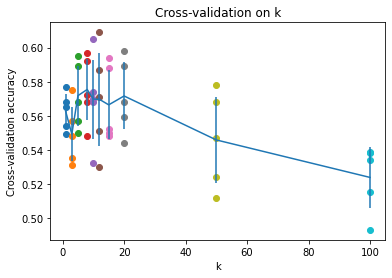

In [12]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()